# Modeling #
It's time to model the hockey data and predict playoff performances. I'm using the same kernel as the hockey_features notebook so variables are shared.

## Preparations ##
Importing packages, creating evaluation functions

In [35]:
import pandas as pd
import time
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from numpy import arange
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from scipy import stats

## Evaluation ##
To properly evaluate the predictions, I must convert the points percentages to playoff seedings. Then I can compare the true playoff standings from those seasons to the predictions and score the predictions

In [36]:
def create_y_score(X_test, y_test, model):
    # Make prediction
    pts_pred = model.predict(X_test)

    # Combine prediction and actual values
    y_score = y_test.drop('PTS%', axis = 1)
    y_score['PTS%_Pred'] = pts_pred

    return y_score

In [37]:
def evaluate_model(X_test, y_test, model):
    ''' (DataFrame, DataFrame, model) -> confusion matrix, classification report
    Returns confusion matrix and classification report for trained model.
    '''
    
    y_score = create_y_score(X_test, y_test, model)

    # Convert predicted points percentage to playoff status
    playoff_preds = create_playoff_preds(y_score, answer_key)

    # Assign boolean columns
    y_true = playoff_preds['True_playoffs'].astype(int)
    y_pred = playoff_preds['Pred_playoffs'].astype(int)
    
    # Generate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names = ['Non-Playoffs', 'Playoffs'], output_dict = True)
    
    return conf_matrix, report

In [38]:
def predict_playoffs(X_test, y_test, model):

    y_score = create_y_score(X_test, y_test, model)

    playoff_preds = create_playoff_preds(y_score, answer_key)

    return playoff_preds.set_index(['Season', 'Team']).loc[:, ['True_playoffs', 'Pred_playoffs']]

## Cross Validation ##
It is important to split the data by season, so that the classification report makes sense later on. Since the number of seasons is rather small, I can use time-series cross validation to evaluate the models as more training data are added.

In [39]:
def cross_validate(X, y, model):
    ''' (DataFrame, DataFrame, model object) -> DataFrame
    Returns a DataFrame of accuracy scores at each training interval for each model
    '''
    model_seasons = X['Season'].unique()
    
    accuracy = np.array([])
    season = np.array([])
    n_train = [i for i in range(1, len(model_seasons))]
    
    for year in model_seasons:
        
        # Skip 2022 since X has no 2023 data
        if year < 2022:  

            # Train on preceding years
            X_train = X.loc[X['Season'] <= year].set_index(['Team', 'Season'])
            y_train = y.loc[y['Season']<= year].set_index(['Team', 'Season'])

            # Test on following year
            X_test = X.loc[X['Season'] == (year + 1)].set_index(['Team', 'Season'])
            y_test = y.loc[X['Season'] == (year + 1)].set_index(['Team', 'Season'])

            model.fit(X_train, y_train)

            # Track accuracy over time
            conf_matrix, report = evaluate_model(X_test, y_test, model)
            score = report['Playoffs']['precision']
            
            accuracy = np.append(accuracy, score)
            season = np.append(season, year)
            
        else:
            pass
    # Add 1 to all years in the season list since we use the following season as the test point
    season += 1
    results = pd.DataFrame({'season': season, 'prediction_accuracy': accuracy, 'training_seasons': n_train})
    
    return results        

### Creating Cross-Validation Subplots ###

In [40]:
def create_subplots(param_list, weighted_mean_accuracy, std_dev_accuracy):
    ''' (Dict, float, float) -> figure, axes objects
    Return figure and axes objects with 2 subplots and a
    suptitle of parameters for the specific model.
    '''
    
    # Create subplots and suptitle
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.subplots_adjust(top=0.8)
    fig.suptitle(f'Model Parameters - {param_list} \n Weighted Mean Accuracy: {weighted_mean_accuracy * 100 : 0.2f}%, Accuracy Standard Deviation: {std_dev_accuracy * 100:0.2f}%', y=0.98)
    
    return fig, axes

In [41]:
def add_data_to_subplots(fig, axes, results):
    ''' (figure object, axes object, DataFrame) -> figure, axes objects
    Return the figure and axes objects with accuracy histogram and 
    accuracy over time data plotted.
    '''
    
    # Add histogram subplot
    sns.histplot(results['prediction_accuracy'], bins = 8, color = 'blue', alpha = 0.7, ax = axes[0])
    axes[0].set_title('Accuracy Histogram')
    axes[0].set_xlabel('Accuracy')
    axes[0].set_ylabel('Frequency')

    # Add line graph subplot
    sns.lineplot(data = results, x = 'season', y = 'prediction_accuracy', marker = 'o', linestyle = '-', color ='green', ax = axes[1])
    axes[1].set_title('Accuracy Over Time')
    axes[1].set_xlabel('Test Year')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid()

    return fig, axes

## OLS Linear Model ##
An ordinary least squares linear regression is a sensible first model to try in a situation like this. It's simple but should capture the general trend of the data reasonably well.

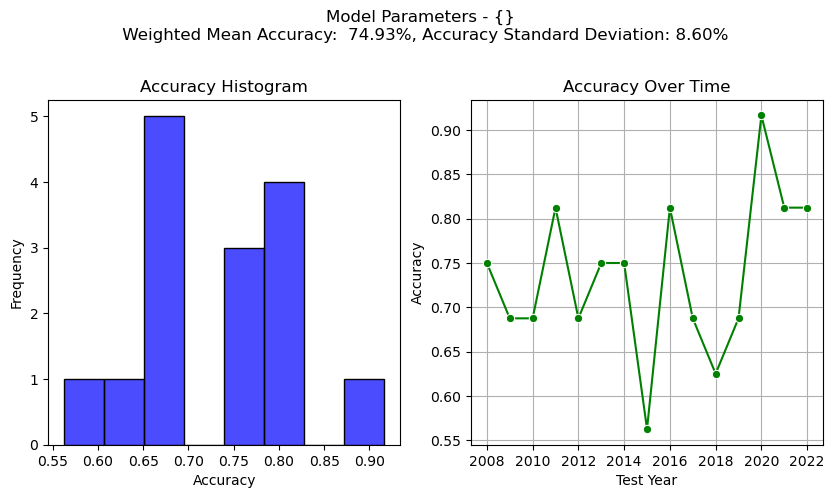

In [42]:
param_list = {}
lin_model = LinearRegression(**param_list)

results = cross_validate(X, y, lin_model)
weighted_mean_acc = np.average(results['prediction_accuracy'], weights = results['training_seasons'])
acc_std = np.std(results['prediction_accuracy'])

fig, axes = create_subplots(param_list, weighted_mean_acc, acc_std)
fig, axes = add_data_to_subplots(fig, axes, results)

# No parameters for OLS, so add a better suptitle
#plt.suptitle('Linear Regression Prediction Accuracy')
plt.show()

It is intriguing that the predictive performance is so poor for 2015. I wonder why that is the case. Perhaps the playoff seeds were lopsided due to odd tiebreakers and wildcard rules. It is exciting to see that the 2020, 2021, and 2022 predictions are so good. Maybe it's easier to predict which teams will be bad, since 2020 had so few teams miss the playoffs. Time to see if the model, when trained on all the data, predicts the 2023 holdout data well.

In [43]:
start = time.time()

lin_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
conf_matrix, report = evaluate_model(X_hold, y_hold, lin_model)

end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

print(conf_matrix)
print(report['Playoffs']['precision'])

Execution time: 00:00
[[10  6]
 [ 6 10]]
0.625


The model correctly predicts 10 out of 16 playoff teams. This isn't terrible but it's actually a rather low accuracy compared to the performance on the previous couple years.

### OLS with PCA ###
Reducing the dimensionality of the data may help my linear model perform better on the data, so I'll try that approach.

In [44]:
def create_PCA(X, X_hold, n_components):
    '''(DataFrame, DataFrame, int) -> DataFrame, DataFrame, PCA object
    Returns PCA for X data and holdout X data, as well as the PCA object itself.
    '''

    X_pre_pca = X.set_index(['Team', 'Season'])
    column_names = X_pre_pca.columns
    X_index_names = X_pre_pca.index
    hold_index_names = X_hold.index
    pca = PCA(n_components = n_components)

    # The training and testing data need to have the index reset for the process of splitting by season.
    # It will be set again later
    X_pca = pd.DataFrame(pca.fit_transform(X_pre_pca),
                         columns = [f'PC{i}' for i in range(1, n_components+1)],
                         index = X_index_names).reset_index(drop = False)

    # The holdout data do not need the index to be reset
    X_hold_pca = pd.DataFrame(pca.transform(X_hold),
                              columns = [f'PC{i}' for i in range(1, n_components+1)],
                              index = hold_index_names)

    return X_pca, X_hold_pca, pca

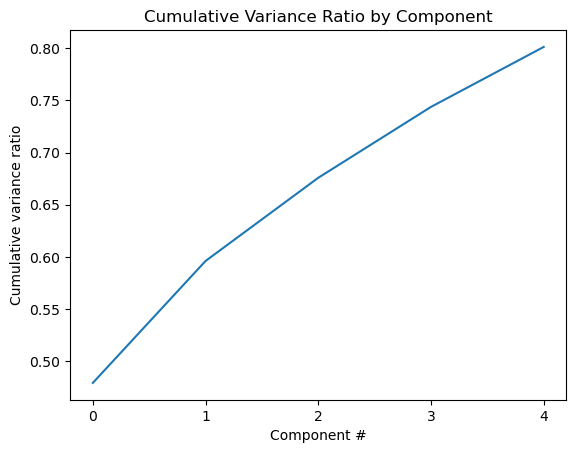

In [45]:
# Performing the PCA with 5 components
X_pca, X_hold_pca, pca = create_PCA(X, X_hold, 5) 

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.xticks(np.arange(0, 5))
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative Variance Ratio by Component')
plt.show()

I can explain about 80% of the variance in the data with 5 components. It's worth a shot to try modeling and evaluating on the transformed data.

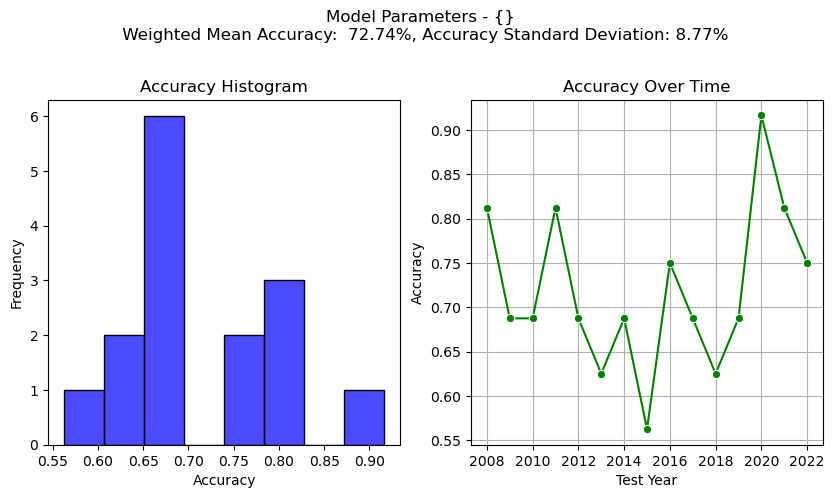

In [46]:
param_list = {}
model = LinearRegression(**param_list)

results = cross_validate(X_pca, y, model)
weighted_mean_acc = np.average(results['prediction_accuracy'], weights = results['training_seasons'])
acc_std = np.std(results['prediction_accuracy'])
fig, axes = create_subplots(param_list, weighted_mean_acc, acc_std)
fig, axes = add_data_to_subplots(fig, axes, results)

plt.show()

In [47]:
# Building best model
lin_pca_model = LinearRegression()
# Training the model on all the data
lin_pca_model.fit(X_pca.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
conf_matrix, report = evaluate_model(X_hold_pca, y_hold, lin_pca_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[10  6]
 [ 6 10]]
0.625


The model's accuracy is generally a little lower, especially in later years. Seems like reality is a little more sensitive to noise. Once again, though, the predictions for 2023 are 62.5% accurate.

## Elastic Net Regression ##
It's time to seek some improvement over the OLS linear model by adding some penalty terms.

In [48]:
def optimize_elastic_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the best performing linear regression models.
    '''
    performance = pd.DataFrame()
    # Pick alpha term
    alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 0.0, 1.0]
    # Pick l1 ratio
    l1_list = arange(0, .5, 0.05)

    models = pd.DataFrame(columns = ['alpha', 'l1_ratio', 'weighted_mean_accuracy', 'std_dev_accuracy'])
    
    for alpha in alpha_list:
        for l1 in l1_list:
            
            param_list = {'alpha': alpha, 'l1_ratio': l1}
            model = ElasticNet(**param_list)
            
            results = cross_validate(X, y, model)
            weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
            acc_std = np.std(results['prediction_accuracy'])

            model_info = pd.DataFrame({'alpha': [alpha], 'l1_ratio': [l1], 'weighted_mean_accuracy': [weighted_mean_acc], 'std_dev_accuracy': [acc_std]})

            models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        mean_acc = top_model.weighted_mean_accuracy
        std_acc = top_model.std_dev_accuracy
        param_list = {'alpha': top_model.alpha, 'l1_ratio': top_model.l1_ratio}
        model = ElasticNet(**param_list)
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        results = cross_validate(X, y, model)
        fig, axes = add_data_to_subplots(fig, axes, results)

    plt.show()

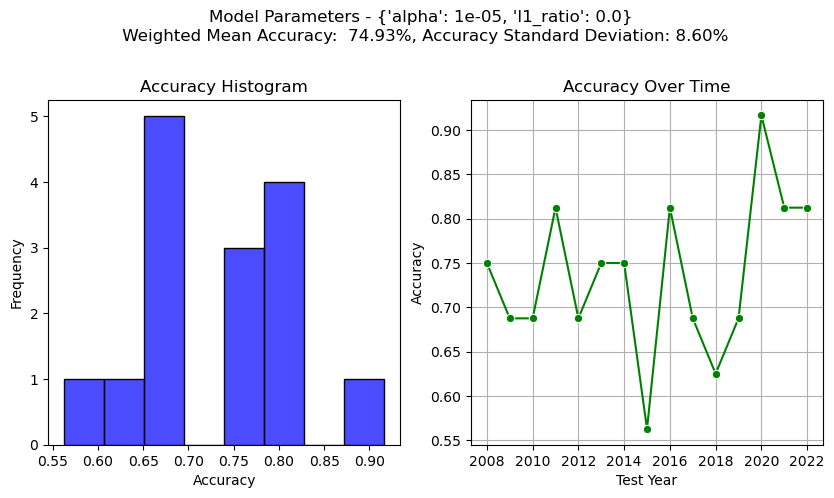

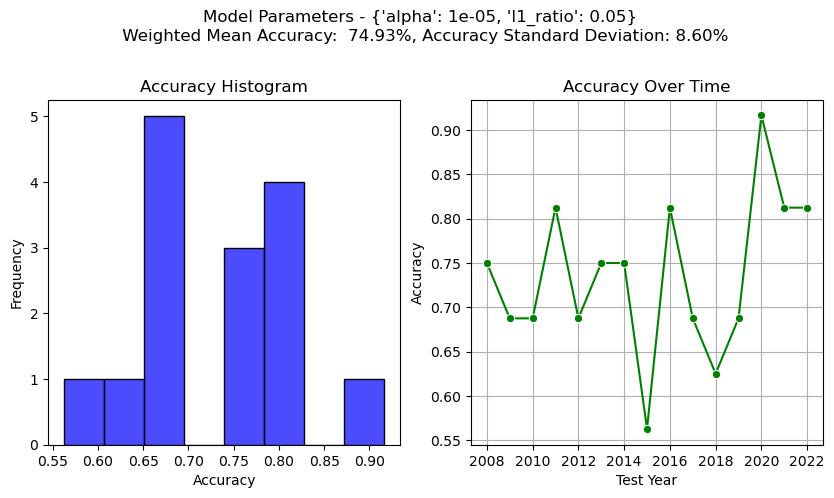

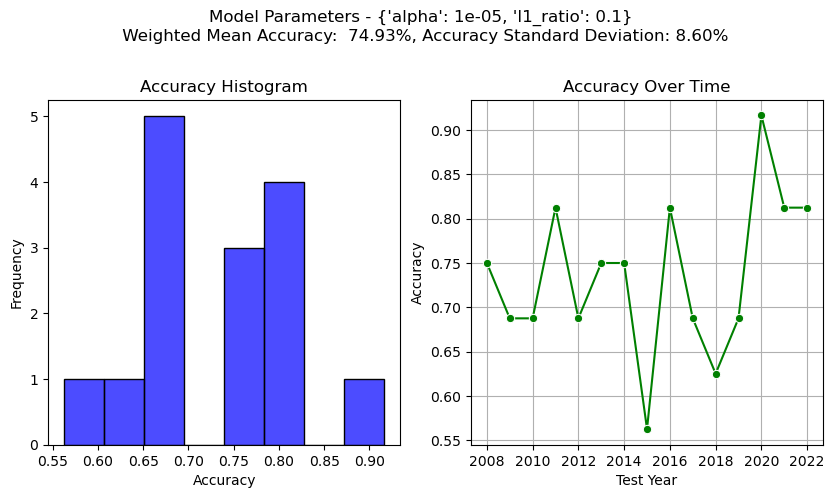

Execution time: 00:38


In [49]:
start = time.time()
optimize_elastic_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [50]:
# Build optimal model from grid search
best_EN_model = ElasticNet(alpha = 1e-05, l1_ratio = 0)
# Training the model on all the data
best_EN_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
# Evaluate optimal model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_EN_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[10  6]
 [ 6 10]]
0.625


After running a number of trials with varying alpha and l1 ratio ranges, I haven't seen any performance improvements over the standard linear model.

## Random Forest Regression ##
Random Forest Regression may be able to capture the interactions between all the features better than a linear model.

In [51]:
def optimize_RFR_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the 3 best performing random forest regression models.
    '''

    # Pick error criterion, eliminated poisson since it was never optimal
    criteria = ['squared_error', 'friedman_mse']#, 'poisson']
    # Pick number of estimators
    n_est_list = [50, 100, 200]
    # Pick max depth, elimiated lower ranges since best models were around 10 nodes deep
    depths = [8, 12, 16]

    models = pd.DataFrame(columns = ['max_depth', 'n_estimators', 'criterion', 'weighted_mean_accuracy', 'std_dev_accuracy'])
    
    for criterion in criteria:
        for n_est in n_est_list:
            for depth in depths:
                
                param_list = {'max_depth': depth,
                              'n_estimators': n_est,
                              'criterion': criterion,
                              'bootstrap' : True,
                              'n_jobs': -1,
                              'random_state': 14}
                
                model = RandomForestRegressor(**param_list)
                
                results = cross_validate(X, y, model)
                weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
                std_acc = np.std(results['prediction_accuracy'])
    
                model_info = pd.DataFrame({'max_depth': [depth],
                                           'n_estimators': [n_est],
                                           'criterion': criterion,
                                           'random_state': 14,
                                           'bootstrap': True,
                                           'n_jobs': -1,
                                           'weighted_mean_accuracy': [weighted_mean_acc],
                                           'std_dev_accuracy': [std_acc]
                                          })
    
                models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'random_state': 'int32', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        mean_acc = top_model.weighted_mean_accuracy
        std_acc = top_model.std_dev_accuracy
        param_list = {
            'max_depth': top_model.max_depth,
            'n_estimators': top_model.n_estimators,
            'criterion': top_model.criterion,
            'random_state': top_model.random_state 
            
        }
        model = RandomForestRegressor(**param_list)
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        results = cross_validate(X, y, model)
        fig, axes = add_data_to_subplots(fig, axes, results)

    plt.show()

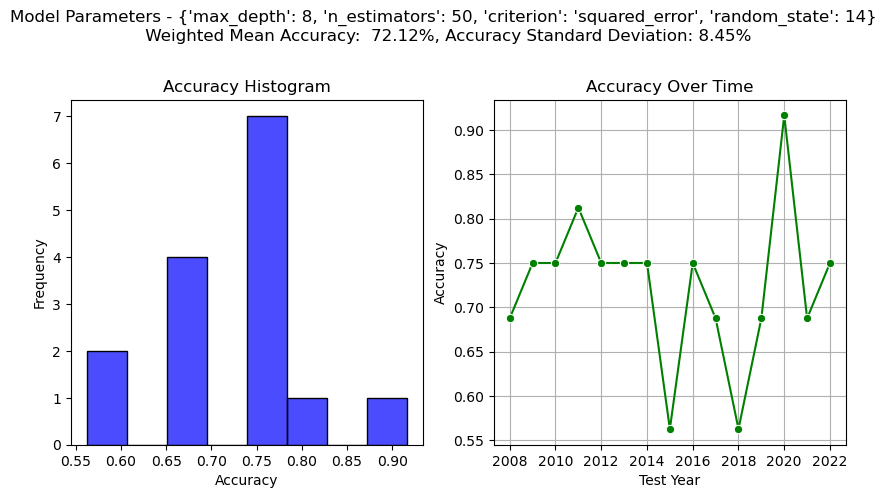

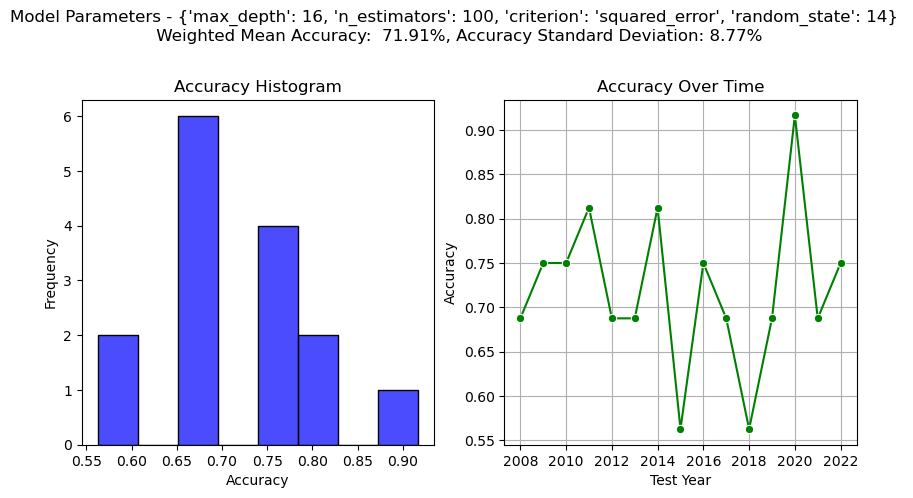

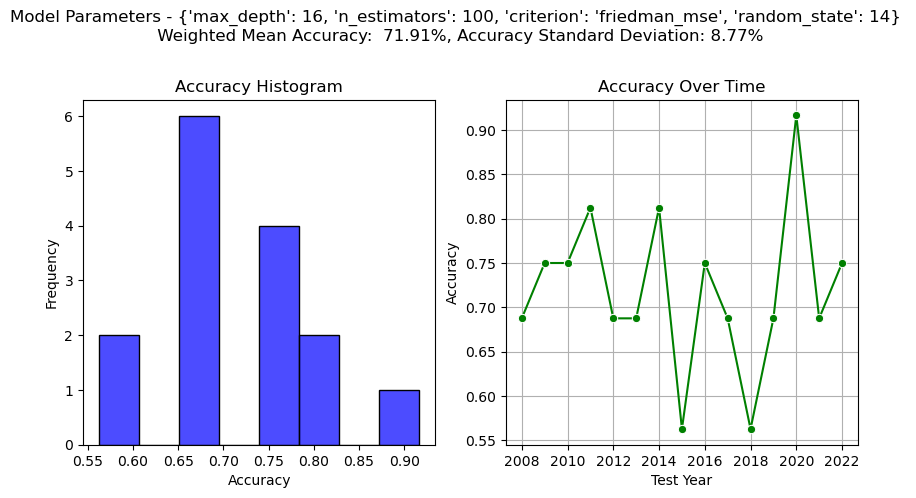

Execution time: 01:05


In [52]:
start = time.time()
optimize_RFR_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [53]:
# Building best model from grid search
best_RFR_model = RandomForestRegressor(criterion = 'squared_error', max_depth = 8, n_estimators = 50, random_state = 14, bootstrap = True)
# Training the model on all the data
best_RFR_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_RFR_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[12  4]
 [ 4 12]]
0.75


Finally! A model has successfully predicted at least 75% of playoff teams for the holdout data. This was the target threshold for the project. Now, I want to explore some other models in order to see if any of them perform just as well or better on the holdout data and improve the test data performance as well.

## Support Vector Regression ##
Support Vector Machine Classifiers find hyperplanes that separate classes. A SVR does something similar with a hyperplane of best fit. I don't know what to expect from it in terms of performance on this dataset. 

In [54]:
def optimize_SVR_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the best performing support vector regression models.
    '''
    # Pick kernel, opting away from linear
    kernel_list = ['rbf', 'sigmoid']
    # Pick number of estimators
    gamma_list = ['scale', 'auto']

    epsilons = [0.01, 0.05, 0.25]

    models = pd.DataFrame(columns = ['kernel', 'gamma', 'weighted_mean_accuracy', 'std_dev_accuracy'])
    
    for kernel in kernel_list:
        for gamma in gamma_list:
            for epsilon in epsilons:
                    
                param_list = {'kernel': kernel,
                              'gamma': gamma,
                              'epsilon': epsilon}
                
                model = SVR(**param_list)
                
                results = cross_validate(X, y, model)
                weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
                std_acc = np.std(results['prediction_accuracy'])
    
                model_info = pd.DataFrame({'kernel': [kernel],
                                           'gamma': [gamma],
                                           'epsilon': [epsilon],
                                           'weighted_mean_accuracy': [weighted_mean_acc],
                                           'std_dev_accuracy': [std_acc]
                                          })
    
                models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        mean_acc = top_model.weighted_mean_accuracy
        std_acc = top_model.std_dev_accuracy
        param_list = {
            'kernel': top_model.kernel,
            'gamma': top_model.gamma,
            'epsilon': top_model.epsilon 
        }
        model = SVR(**param_list)
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        results = cross_validate(X, y, model)
        fig, axes = add_data_to_subplots(fig, axes, results)

    plt.show()

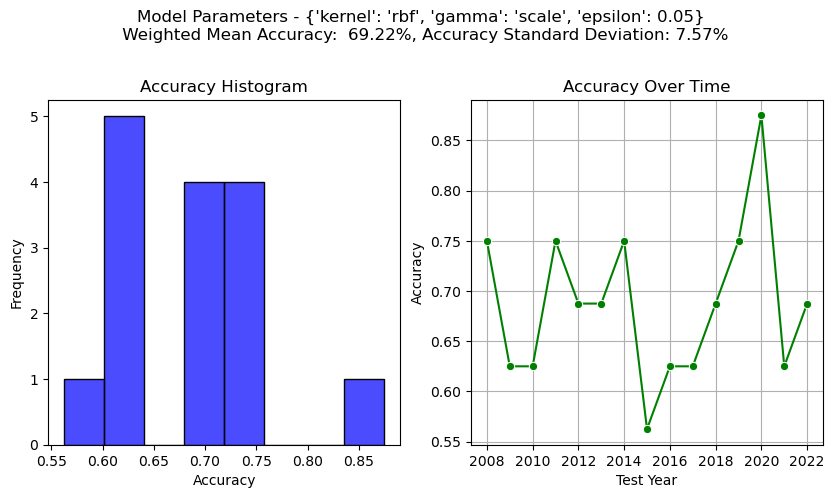

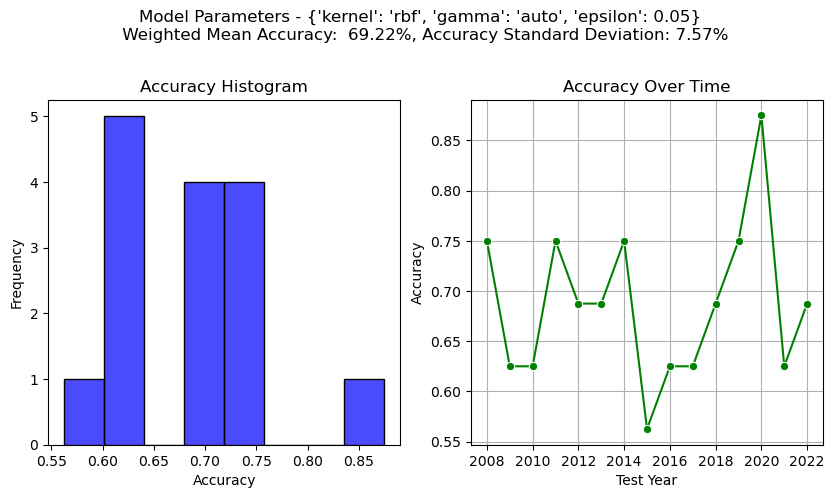

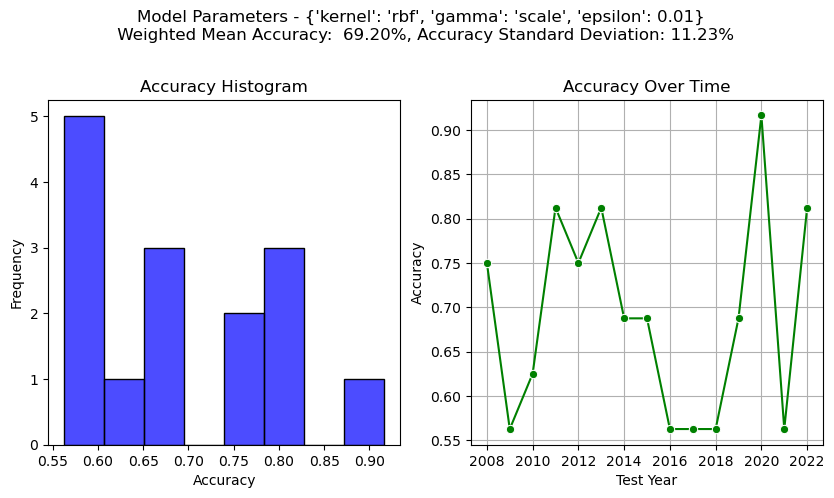

Execution time: 00:10


In [55]:
start = time.time()
optimize_SVR_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [56]:
# Building the optimal model
best_SVR_model = SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.05)
# Training the model on all the data
best_SVR_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_SVR_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[12  4]
 [ 4 12]]
0.75


The Support Vector Regressor achieved the same accuracy as the Random Forest Regressor, despite having a lower mean accuracy. I'm curious to know if the playoff team picks overlapped with the Random Forest model.

## LightGBM Regression ##
LGBM Regression isn't terribly different from Random Forest Regression, but it has more parameters to tune and can achieve better performance, depending on the data and parameters.

In [57]:
def optimize_GBM_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the best performing LightGBM regression models.
    '''

    # Pick boosting type
    boost_list = ['gbdt', 'dart']
    # Pick number of leaves
    leaf_list = [5, 8, 12]
    # Set max depth
    depth_list = [5, 8, 16]

    data_list = [4, 8, 16]

    verbosity = -1

    force_col_wise = True

    random_state = 14
    
    models = pd.DataFrame(columns = ['boosting_type', 'max_depth', 'num_leaves','min_data_in_leaf', 'random_state', 'weighted_mean_accuracy', 'verbosity', 'force_col_wise', 'std_dev_accuracy'])

    for boosting_type in boost_list:
        for num_leaves in leaf_list:
            for max_depth in depth_list:
                for min_data_in_leaf in data_list:
                    
                    param_list = {'boosting_type': boosting_type,
                                  'num_leaves': num_leaves,
                                  'max_depth': max_depth,
                                  'min_data_in_leaf': min_data_in_leaf,
                                  'random_state': random_state,
                                  'verbosity': verbosity,
                                  'force_col_wise': force_col_wise
                                 }
                    model = LGBMRegressor(**param_list)
                    
                    results = cross_validate(X, y, model)
                    weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
                    std_acc = np.std(results['prediction_accuracy'])
        
                    model_info = pd.DataFrame({'boosting_type': [boosting_type],
                                                'num_leaves': [num_leaves],
                                                'max_depth': [max_depth],
                                                'min_data_in_leaf': [min_data_in_leaf],
                                                'random_state': [random_state],
                                                'verbosity': [verbosity],
                                                'force_col_wise': [force_col_wise],
                                                'weighted_mean_accuracy': [weighted_mean_acc],
                                                'std_dev_accuracy': [std_acc] 
                                              })
        
                    models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'random_state': 'int32', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        mean_acc = top_model.weighted_mean_accuracy
        std_acc = top_model.std_dev_accuracy
        param_list = {'boosting_type': top_model.boosting_type,
                      'num_leaves': top_model.num_leaves,
                      'max_depth': top_model.max_depth,
                      'min_data_in_leaf': top_model.min_data_in_leaf,
                      'random_state': top_model.random_state,
                      'verbosity': top_model.verbosity,
                      'force_col_wise': top_model.force_col_wise
                    }
        
        model = LGBMRegressor(**param_list)
        
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        results = cross_validate(X, y, model)
        fig, axes = add_data_to_subplots(fig, axes, results)
    plt.show()

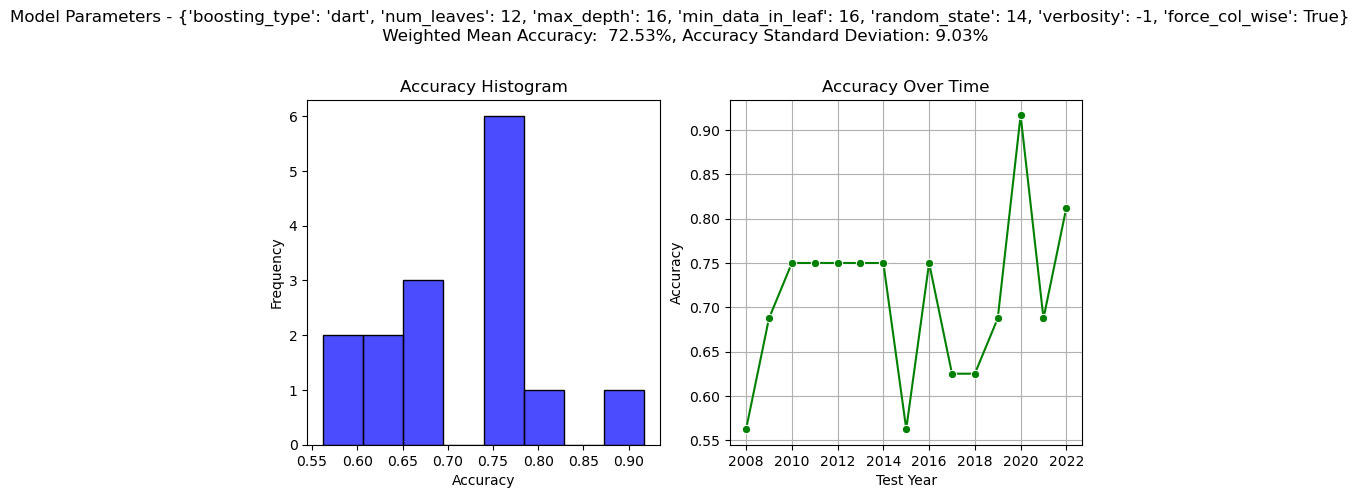

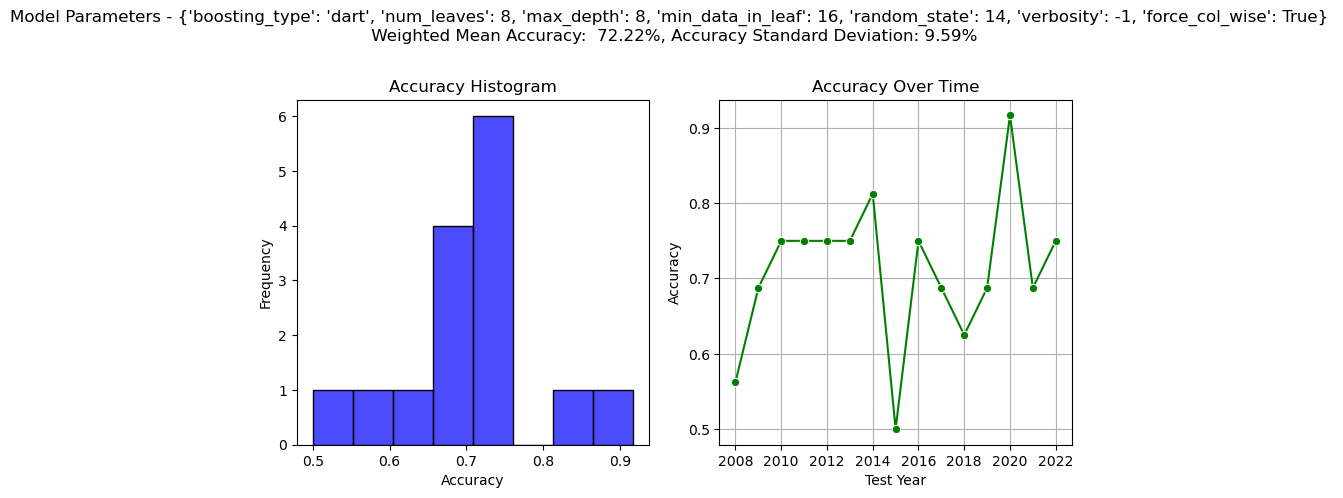

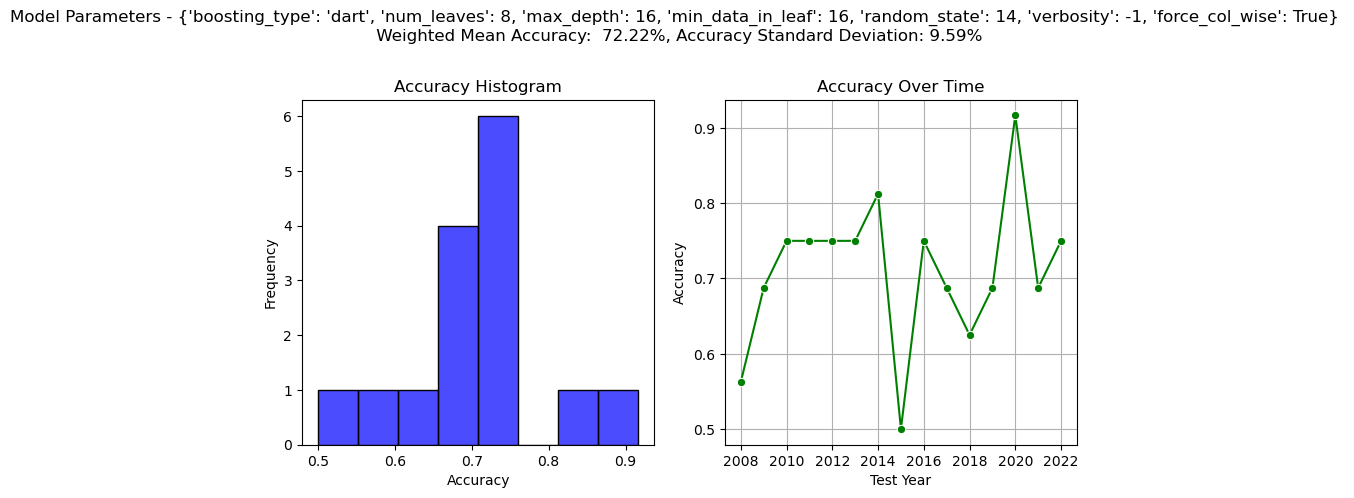

Execution time: 01:11


In [58]:
start = time.time()
optimize_GBM_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [59]:
# Building the optimal model
best_GBM_model = LGBMRegressor(boosting_type = 'dart', num_leaves = 12, max_depth = 16, random_state = 14, min_data_in_leaf = 16, verbosity = -1, force_col_wise = True)
# Training the model on all the data
best_GBM_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_GBM_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[12  4]
 [ 4 12]]
0.75


The LightGBM Regressor model has also hit the 75% accuracy threshold. I'll try a couple more types of model to see if it's possible to consistently improve on this number.

## Polynomial Regression ##
Trying a variety of polynomial curves might fit better than linear models did earlier.

In [60]:
def poly_cross_validate(X, y, degree):
    ''' (DataFrame, DataFrame, model object) -> DataFrame
    Returns a DataFrame of accuracy scores at each training interval for each polynomial regression model
    '''
    model_seasons = X['Season'].unique()
    
    accuracy = np.array([])
    season = np.array([])
    n_train = [i for i in range(1, len(model_seasons))]
    
    

    for year in model_seasons:
        
        # Skip 2022 since X has no 2023 data
        if year < 2022:  

            # Train on preceding years
            X_train = X.loc[X['Season'] <= year].set_index(['Team', 'Season'])
            y_train = y.loc[y['Season']<= year].set_index(['Team', 'Season'])

            # Test on following year
            X_test = X.loc[X['Season'] == (year + 1)].set_index(['Team', 'Season'])
            y_test = y.loc[X['Season'] == (year + 1)].set_index(['Team', 'Season'])

            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            
            # Track accuracy over time
            conf_matrix, report = evaluate_model(X_test_poly, y_test, model)
            score = report['Playoffs']['precision']
            
            accuracy = np.append(accuracy, score)
            season = np.append(season, year)
            
        else:
            pass
    season += 1
    results = pd.DataFrame({'season': season, 'prediction_accuracy': accuracy, 'training_seasons': n_train})
    
    return results        

In [61]:
# Optimizing the polynomial model
def optimize_poly_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the best performing polynomial regression model as well as its accuracy score and the random
    seed which generated the train-test split of the input data.
    '''

    degrees = [2, 3, 4, 5, 6, 7]

    models = pd.DataFrame(columns = ['degree', 'weighted_mean_accuracy', 'std_dev_accuracy'])

    for degree in degrees:

        results = poly_cross_validate(X, y, degree)
        
        weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
        std_acc = np.std(results['prediction_accuracy'])
        
        model_info = pd.DataFrame({'degree': [degree],
                                    'weighted_mean_accuracy': [weighted_mean_acc],
                                  'std_dev_accuracy': std_acc})

        models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        
        mean_acc = top_model.weighted_mean_accuracy
        std_acc = top_model.std_dev_accuracy
        param_list = {'degree': top_model.degree}
        degree = top_model.degree
        
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        results = poly_cross_validate(X, y, degree)
        fig, axes = add_data_to_subplots(fig, axes, results)

    plt.show()

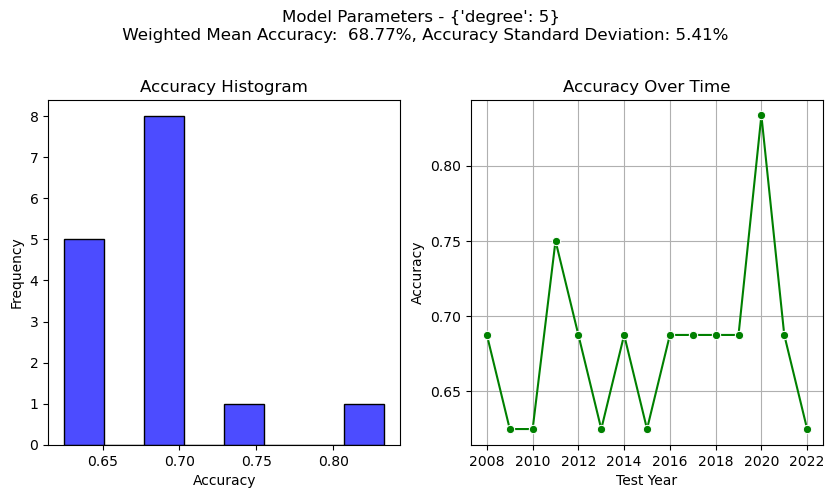

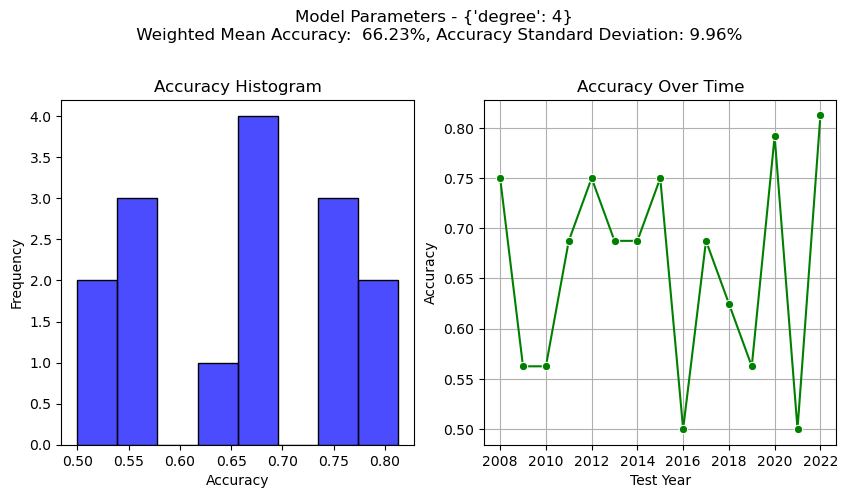

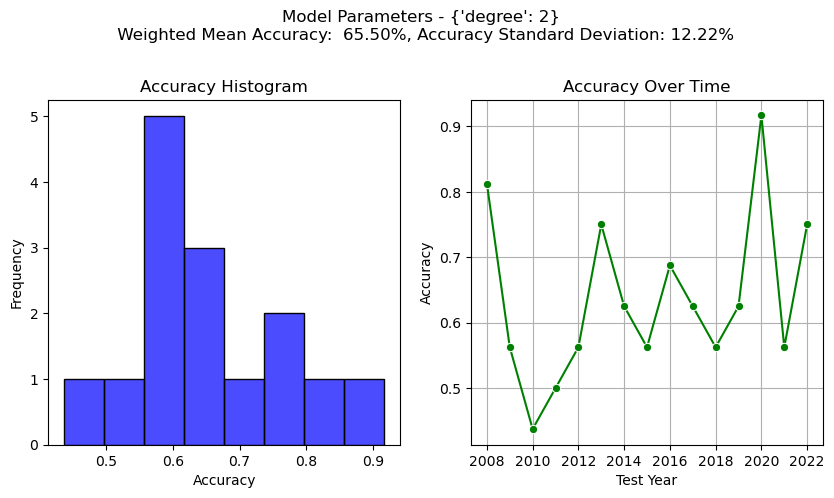

Execution time: 00:30


In [62]:
start = time.time()
optimize_poly_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [63]:
# Building the optimal model
poly = PolynomialFeatures(degree=5)
# Training the model on all the data
X_poly = poly.fit_transform(X.set_index(['Team', 'Season']))
X_hold_poly = poly.transform(X_hold)
lin_poly_model = LinearRegression()
lin_poly_model.fit(X_poly, y.set_index(['Team', 'Season']))
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold_poly, y_hold, lin_poly_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[11  5]
 [ 5 11]]
0.6875


When trained on the whole dataset, the 2nd and 5th degree polynomial regression models performed slightly underwhelmingly on the holdout data, with 11/16 correct predictions. The 4th degree model barely got above 50%, with 9/16 correct predictions. The overall accuracy of the polynomial regression models is relatively low, meaning they aren't a great fit for these data in general.

## Bayesian Ridge Regression ##

In [64]:
def optimize_bayesian_ridge_model(X, y):
    ''' (DataFrame, DataFrame) -> fig, axes objects
    Returns the best performing bayesian ridge regression models.
    '''

    
    alpha_1_list = [1e-6, 1]
    alpha_2_list = [1e-6, 1]
    alpha_init_list = [None, 1]
    
    lambda_1_list = [1e-6, 1]
    lambda_2_list = [1e-6, 1]
    lambda_init_list = [0, 1e-3, 1]
    
    
    models = pd.DataFrame(columns = ['alpha_1', 'alpha_2', 'alpha_init','lambda_1', 'lambda_2', 'lambda_init', 'weighted_mean_accuracy', 'std_dev_accuracy'])

    for alpha_1 in alpha_1_list:
        for alpha_2 in alpha_2_list:
            for lambda_1 in lambda_1_list:
                for lambda_2 in lambda_2_list:
                    for alpha_init in alpha_init_list:
                        for lambda_init in lambda_init_list:
                        
                    
                            param_list = {'alpha_1': alpha_1,
                                          'alpha_2': alpha_2,
                                          'alpha_init': alpha_init,
                                          'lambda_1': lambda_1,
                                          'lambda_2': lambda_2,
                                          'lambda_init': lambda_init
                                         }
                            
                            model = BayesianRidge(**param_list)
                            
                            results = cross_validate(X, y, model)
                            
                            weighted_mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
                            
                            std_acc = np.std(results['prediction_accuracy'])
                
                            model_info = pd.DataFrame({'alpha_1': [alpha_1],
                                                       'alpha_2': [alpha_2],
                                                       'alpha_init': [alpha_init],
                                                       'lambda_1': [lambda_1],
                                                       'lambda_2': [lambda_2],
                                                       'lambda_init': [lambda_init],
                                                       'weighted_mean_accuracy': [weighted_mean_acc],
                                                       'std_dev_accuracy': [std_acc]
                                                      })
                
                            models = models.append(model_info, ignore_index = True)


    top_models = models.nlargest(3, 'weighted_mean_accuracy').astype({'weighted_mean_accuracy': 'float64', 'std_dev_accuracy': 'float64'})

    for top_model in top_models.itertuples(index=False):
        
        #mean_acc = top_model.weighted_mean_accuracy
        #std_acc = top_model.std_dev_accuracy
        
        param_list = {'alpha_1': top_model.alpha_1,
                      'alpha_2': top_model.alpha_2,
                      'alpha_init': top_model.alpha_init,
                      'lambda_1': top_model.lambda_1,
                      'lambda_2': top_model.lambda_2,
                      'lambda_init': top_model.lambda_init
                    }
        
        model = BayesianRidge(**param_list)
        
        results = cross_validate(X, y, model)
        
        mean_acc = np.average(results['prediction_accuracy'], weights=results['training_seasons'])
        std_acc = np.std(results['prediction_accuracy'])
        
        fig, axes = create_subplots(param_list, mean_acc, std_acc)
        
        fig, axes = add_data_to_subplots(fig, axes, results)

    plt.show()


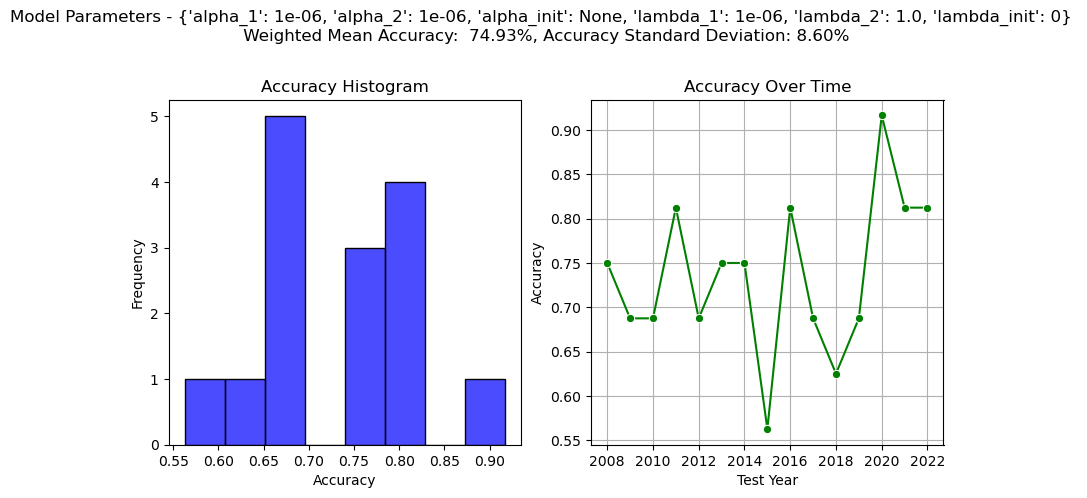

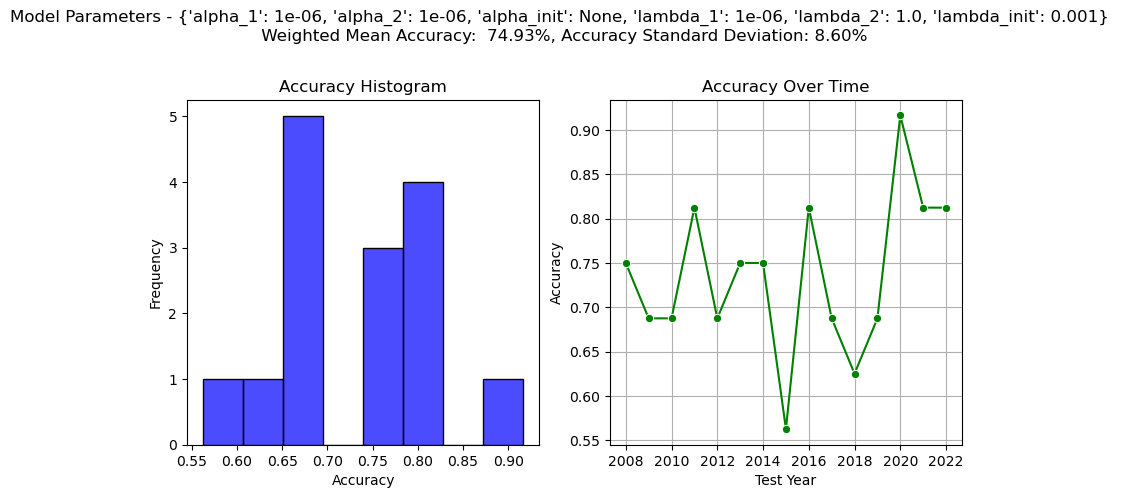

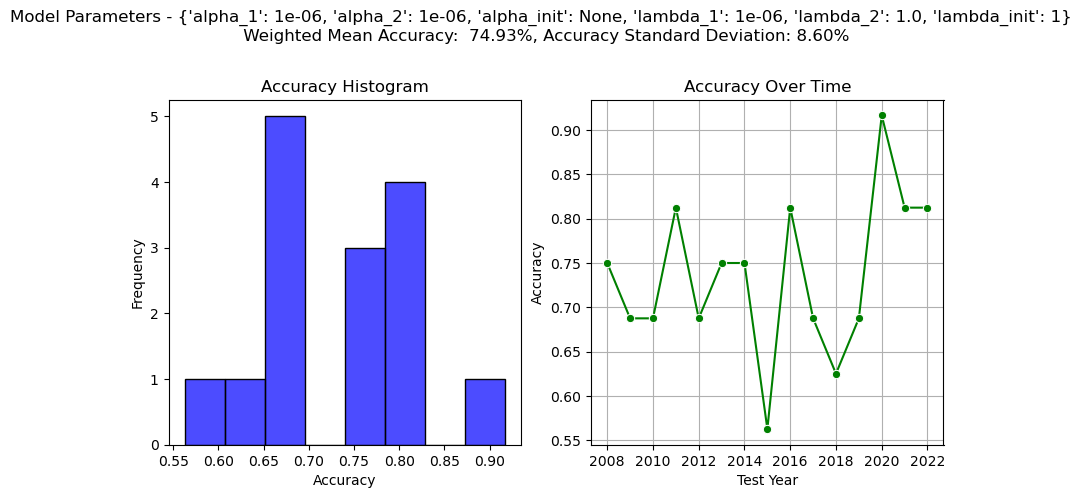

Execution time: 01:18


In [65]:
start = time.time()
optimize_bayesian_ridge_model(X, y)
end = time.time()
elapsed_time = end - start

print('Execution time:', time.strftime('%M:%S', time.gmtime(elapsed_time)))

In [66]:
# Building the optimal model
best_bayesian_regression_model = BayesianRidge(alpha_1 = 1e-6, alpha_2 = 1e-6, alpha_init = None, lambda_1 = 1e-6, lambda_2 = 1, lambda_init = 0)
# Training the model on all the data
best_bayesian_regression_model.fit(X.set_index(['Team', 'Season']), y.set_index(['Team', 'Season']))
# Evaluate model on holdout data
conf_matrix, report = evaluate_model(X_hold, y_hold, best_bayesian_regression_model)
print(conf_matrix)
print(report['Playoffs']['precision'])

[[10  6]
 [ 6 10]]
0.625


The Bayesian Ridge Regression model hasn't been able to exceed the 10/16 threshold. Next, I'll evaluate some ensemble options.

## Ensemble Approach ##
I want to take a look at how the predictions compare to one another. Maybe averaging some of the better models can get us closer to reality. The models with linear regression foundations (polynomial, linear, bayesian, and elastic net) tended to perform worse than the decision tree based random forest and LightGBM and the hyperplane-finding SVR. I'll check the average prediction when including and excluding the linear models.

In [67]:
# Generate prediction arrays for each tuned model
lin_pts_preds = lin_model.predict(X_hold)
EN_pts_preds = best_EN_model.predict(X_hold)
RFR_pts_preds = best_RFR_model.predict(X_hold)
SVR_pts_preds = best_SVR_model.predict(X_hold)
GBM_pts_preds = best_GBM_model.predict(X_hold)
poly_pts_preds = lin_poly_model.predict(X_hold_poly)
bayesian_pts_preds = best_bayesian_regression_model.predict(X_hold)

In [68]:
# Create a DataFrame with a column for each model's predictions, as well as an average of select predictions
pts_preds = (answer_key
            .copy()
            .loc[(answer_key['Season'] == 2023), ['Season', 'Team', 'Conf', 'Div', 'PTS%']]
            .assign(
                Linear_PTS = lin_pts_preds,
                #EN_PTS = EN_pts_preds,
                #RFR_PTS = RFR_pts_preds,
                SVR_PTS = SVR_pts_preds,
                LightGBM_PTS = GBM_pts_preds,
                #Polynomial_PTS = poly_pts_preds,
                #Bayesian_PTS = bayesian_pts_preds
            )
            .sort_values(by = ['Conf', 'Div', 'PTS%'], ascending = [True, True, False])
            .set_index(['Season', 'Conf', 'Div', 'Team'])
            .round(3)
            )

pts_preds['Average_PTS'] = (pts_preds
                            .iloc[:, 1:]
                            .mean(axis=1)
                            .round(3)
                           )
pts_preds

PTS%  Linear_PTS  SVR_PTS  LightGBM_PTS  Average_PTS
Season Conf Div Team                                                       
2023   East Atl BOS   0.823       0.611    0.695         0.567        0.624
                TOR   0.677       0.623    0.657         0.589        0.623
                TBL   0.598       0.618    0.559         0.557        0.578
                FLA   0.561       0.611    0.610         0.574        0.598
                BUF   0.555       0.481    0.458         0.427        0.455
                OTT   0.524       0.536    0.493         0.483        0.504
                DET   0.488       0.481    0.447         0.422        0.450
                MTL   0.415       0.439    0.462         0.414        0.438
            Met CAR   0.689       0.587    0.632         0.547        0.589
                NJD   0.683       0.517    0.446         0.447        0.470
                NYR   0.652       0.638    0.647         0.582        0.622
                NYI   0.567       0.536    0.580         0.538        0.551
                PIT   0.555       0.585    0.541         0.530        0.552
                WSH   0.488       0.591    0.537         0.531        0.553
                PHI   0.457       0.497    0.534         0.467        0.499
                CBJ   0.360       0.540    0.548         0.520        0.536
       West Cen COL   0.665       0.613    0.600         0.540        0.584
                DAL   0.659       0.562    0.558         0.542        0.554
                MIN   0.628       0.611    0.638         0.555        0.601
                WPG   0.579       0.564    0.560         0.478        0.534
                NSH   0.561       0.622    0.623         0.576        0.607
                STL   0.494       0.579    0.587         0.537        0.568
                ARI   0.427       0.477    0.437         0.421        0.445
                CHI   0.360       0.509    0.465         0.430        0.468
            Pac VEG   0.677       0.558    0.632         0.552        0.581
                EDM   0.665       0.597    0.711         0.553        0.620
                LAK   0.634       0.567    0.578         0.513        0.553
                SEA   0.610       0.457    0.442         0.389        0.429
                CGY   0.567       0.656    0.613         0.559        0.609
                VAN   0.506       0.589    0.485         0.496        0.523
                SJS   0.366       0.489    0.513         0.414        0.472
                ANA   0.354       0.517    0.493         0.471        0.494

In [69]:
# Generate playoff predictions from the predicted points percentages for each model
lin_playoff_preds = predict_playoffs(X_hold, y_hold, lin_model).loc[:,['Pred_playoffs']].to_numpy()
EN_playoff_preds = predict_playoffs(X_hold, y_hold, best_EN_model).loc[:, ['Pred_playoffs']].to_numpy()
RFR_playoff_preds = predict_playoffs(X_hold, y_hold, best_RFR_model).loc[:, ['Pred_playoffs']].to_numpy()
SVR_playoff_preds = predict_playoffs(X_hold, y_hold, best_SVR_model).loc[:, ['Pred_playoffs']].to_numpy()
GBM_playoff_preds = predict_playoffs(X_hold, y_hold, best_GBM_model).loc[:, ['Pred_playoffs']].to_numpy()
poly_playoff_preds = predict_playoffs(X_hold_poly, y_hold, lin_poly_model).loc[:, ['Pred_playoffs']].to_numpy()
bayesian_playoff_preds = predict_playoffs(X_hold, y_hold, best_bayesian_regression_model).loc[:, ['Pred_playoffs']].to_numpy()

In [70]:
# Create a DataFrame of predicted playoff statuses for all models and the average prediction of select models
playoffs_preds = (answer_key
                  .copy()
                  .loc[(answer_key['Season'] == 2023), ['Season', 'Team', 'Conf', 'Div', 'True_playoffs', 'PTS%']]
                  .assign(
                      Linear_playoffs = lin_playoff_preds,
                      #EN_playoffs = EN_playoff_preds,
                      #RFR_playoffs = RFR_playoff_preds,
                      SVR_playoffs = SVR_playoff_preds,
                      GBM_playoffs = GBM_playoff_preds,
                      #Polynomial_playoffs = poly_playoff_preds,
                      #Bayesian_playoffs = bayesian_playoff_preds,
                      )
                  .sort_values(by = ['Conf', 'Div', 'PTS%'], ascending = [True, True, False])
                  .set_index(['Season', 'Conf', 'Div', 'Team'])
                  .drop('PTS%', axis = 1)
                  .astype('int')
                 )

playoffs_preds['Average_playoffs'] = (playoffs_preds
                            .iloc[:, 1:]
                            .mean(axis=1)
                            .round(0)
                            .astype('int')
                           )
playoffs_preds

True_playoffs  Linear_playoffs  SVR_playoffs  \
Season Conf Div Team                                                 
2023   East Atl BOS               1                1             1   
                TOR               1                1             1   
                TBL               1                1             1   
                FLA               1                1             1   
                BUF               0                0             0   
                OTT               0                0             0   
                DET               0                0             0   
                MTL               0                0             0   
            Met CAR               1                1             1   
                NJD               1                0             0   
                NYR               1                1             1   
                NYI               1                0             1   
                PIT               0                1             0   
                WSH               0                1             0   
                PHI               0                0             0   
                CBJ               0                0             1   
       West Cen COL               1                1             1   
                DAL               1                0             0   
                MIN               1                1             1   
                WPG               1                0             0   
                NSH               0                1             1   
                STL               0                1             1   
                ARI               0                0             0   
                CHI               0                0             0   
            Pac VEG               1                0             1   
                EDM               1                1             1   
                LAK               1                1             1   
                SEA               1                0             0   
                CGY               0                1             1   
                VAN               0                1             0   
                SJS               0                0             0   
                ANA               0                0             0   

                      GBM_playoffs  Average_playoffs  
Season Conf Div Team                                  
2023   East Atl BOS              1                 1  
                TOR              1                 1  
                TBL              1                 1  
                FLA              1                 1  
                BUF              0                 0  
                OTT              0                 0  
                DET              0                 0  
                MTL              0                 0  
            Met CAR              1                 1  
                NJD              0                 0  
                NYR              1                 1  
                NYI              1                 1  
                PIT              0                 0  
                WSH              1                 1  
                PHI              0                 0  
                CBJ              0                 0  
       West Cen COL              1                 1  
                DAL              1                 0  
                MIN              1                 1  
                WPG              0                 0  
                NSH              1                 1  
                STL              1                 1  
                ARI              0                 0  
                CHI              0                 0  
            Pac VEG              1                 1  
                EDM              1                 1  
                LAK              0                 1  
                SEA              0            

In [71]:
# Evaluate the average prediction
conf_matrix = confusion_matrix(playoffs_preds['True_playoffs'], playoffs_preds['Average_playoffs'])
report = classification_report(playoffs_preds['True_playoffs'], playoffs_preds['Average_playoffs'], target_names = ['Playoffs', 'Non-Playoffs'], output_dict = True)
print(f"{conf_matrix}\n Accuracy: {report['Playoffs']['precision']*100}%")

[[12  4]
 [ 4 12]]
 Accuracy: 75.0%


Averaging the predictions from the Linear, LightGBM, and Support Vector Regressors achieved a 75% accurate playoff prediction for the 2022-23 NHL season. After researching predictions from before the season, I actually couldn't find any experts who had achieved this level of accuracy. The next test will be 2024 predictions!

## 2024 Predictions ##
The 2023-24 NHL season is underway, which means rosters are official and I can predict the playoff teams for this season!

In [72]:
# Create linear model with all data
linear_24 = LinearRegression()
linear_24.fit(X_all, y_all)
# Create LightGBM model with all data
GBM_24 = LGBMRegressor(boosting_type = 'dart', num_leaves = 12, max_depth = 16, random_state = 14, min_data_in_leaf = 16, verbosity = -1, force_col_wise = True)
GBM_24.fit(X_all, y_all)
# Create SVR model with all data
SVR_24 = SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.05)
SVR_24.fit(X_all, y_all);

In [73]:
# Write a function to predict the 2024 playoff teams since there is no "answer key"
def predict_24_playoffs(X_24, model):
    y_score = pd.DataFrame(model.predict(X_24), index = X_24.index).rename(columns = {0: 'PTS%_Pred'})
    
    playoff_preds = (create_playoff_preds(y_score, answer_key)
                        .sort_values(by = ['Conf', 'Div', 'PTS%_Pred'], ascending = [True, True, False])
                        .set_index(['Season', 'Conf', 'Div', 'Team'])
                        .drop(['PTS%', 'True_playoffs'], axis = 1)
                        .round(3)
                        .astype({'Pred_playoffs':'int'})
                    )
    
    return playoff_preds

In [74]:
# Get predictions from each of the three models
linear_24_preds = predict_24_playoffs(X_24, linear_24)
GBM_24_preds = predict_24_playoffs(X_24, GBM_24)['PTS%_Pred']
SVR_24_preds = predict_24_playoffs(X_24, SVR_24)['PTS%_Pred']

In [75]:
# The models' predictions tend to be out of scale with one another, which makes it difficult to take an average. 
# The boolean values also were spread out in such a way that no 16 teams got 2/3 votes
# Instead, I'll scale the PTS% predictions, then average them, then get 16 playoff team predictions 
playoffs_24_preds = (linear_24_preds
                    .copy()
                    .assign(
                        SVR_pts = SVR_24_preds,
                        GBM_pts = GBM_24_preds,
                        )
                     .drop('Pred_playoffs', axis = 1)
                    )
# Scaling each column
pts_scaler = StandardScaler()
scaled_preds = pts_scaler.fit_transform(playoffs_24_preds)

scaled_24_preds = (linear_24_preds
                   .copy()
                   .assign(
                       linear_scaled = scaled_preds[:, 0],
                       SVR_scaled = scaled_preds[:, 1],
                       GBM_scaled = scaled_preds[:, 2]
                   )
                   .drop(['Pred_playoffs', 'PTS%_Pred'], axis = 1)
                  )

scaled_24_preds['Avg_scaled_PTS%'] = (scaled_24_preds
                                .mean(axis=1)
                                .round(3)
                           )

In [76]:
y_score = pd.DataFrame(scaled_24_preds['Avg_scaled_PTS%']).rename(columns = {'Avg_scaled_PTS%': 'PTS%_Pred'}).reset_index(drop = False).drop(['Conf', 'Div'], axis = 1)

# Generating predictions from scaled predicted points percentages
playoff_preds = (create_playoff_preds(y_score, answer_key)
                        .sort_values(by = ['Conf', 'Div', 'PTS%_Pred'], ascending = [True, True, False])
                        .set_index(['Season', 'Conf', 'Div', 'Team'])
                        .drop(['index', 'PTS%_Pred', 'PTS%', 'True_playoffs'], axis = 1)
                        .round(3)
                        .astype({'Pred_playoffs':'int'})
                    )

playoff_preds.loc[playoff_preds['Pred_playoffs'] == 1]

Pred_playoffs
Season Conf Div Team               
2024   East Atl BOS               1
                TBL               1
                TOR               1
                BUF               1
            Met NJD               1
                NYR               1
                NYI               1
                CAR               1
       West Cen COL               1
                DAL               1
                MIN               1
                WPG               1
            Pac EDM               1
                VEG               1
                LAK               1
                SEA               1

## Predictions ##
The playoff teams for 2024 will be:

### East ###
#### Atlantic ####
* Boston Bruins
* Tampa Bay Lightning
* Toronto Maple Leafs
* Buffalo Sabres

#### Metropolitan ####
* New Jersey Devils
* New York Rangers
* New York Islanders
* Carolina Hurricanes

### West ###
#### Central ####
* Colorado Avalanche
* Dallas Stars
* Minnesota Wild
* Winnipeg Jets

#### Pacific ####
* Edmonton Oilers
* Vegas Golden Knights
* Los Angeles Kings
* Seattle Kraken

Time will tell how the model performed!